# Introdução
O que a empresa busca é otimizar a personalização de playlists para o público de ambas cidades, melhorando a experiência com o aplicativo. Para isso algumas hipóteses foram levantadas acerca do comportamento do público que serão testadas a seguir.

Será verificado se há diferença no comportamento dos clientes de duas cidades (Shelbyville e Springfield) em dias específicos (Seg. Qua. e Sex.) conforme solicitado.

__As hipóteses a serem testadas são:__

* o dia da semana tem influência na quantidade de faixas escutadas em cada cidade
* existem horários de pico
* cada cidade tem uma maior preferência por certos gêneros musicais
* cada cidade tem preferências diferentes nos horários de pico

__Dicionário de dados:__
* 'userID' — id do usuário
* 'track' — título da faixa
* 'artist' — nome do artista
* 'genre' — gênero musical
* 'city' — cidade do usuário
* 'time' — a hora em que a faixa foi reproduzida
* 'day' — dia da semana em que a faixa foi reproduzida

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

In [2]:
df = pd.read_csv('datasets/music_project_en.csv')

In [3]:
df.head()

,userID,Track,artist,genre,City,time,Day
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Shelbyville,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Springfield,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Shelbyville,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Shelbyville,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,dance,Springfield,08:34:34,Monday


In [4]:
df.shape

(65079, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     userID  65079 non-null  object
 1   Track     63736 non-null  object
 2   artist    57512 non-null  object
 3   genre     63881 non-null  object
 4     City    65079 non-null  object
 5   time      65079 non-null  object
 6   Day       65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


In [6]:
df.columns

Index(['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day'], dtype='object')

In [7]:
df.duplicated().sum()

3826

In [8]:
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False)

artist      11.627407
Track        2.063646
genre        1.840840
  userID     0.000000
  City       0.000000
time         0.000000
Day          0.000000
dtype: float64

  
---
Constatações:
* 65079 registros e 7 features
* 3950 registros duplicados
* presença de Missing values
* problema com nomes das features (espaços)
* tipo inválido (time)

# Preprocessing
A seguir os dados serão tratados e os problemas encotrados serão corrigidos, e uma feature adicional será criada para enriquecer a análise.

In [9]:
# renaming wrong genres
def replace_wrong_genres(_df, col, wrong_genres, correct_genre):
    df_genres = _df[col]
    for v in wrong_genres:
        df_genres[df_genres == v] = correct_genre

replace_wrong_genres(df, 'genre', ['hip', 'hop', 'hip-hop'], 'hiphop')

In [10]:
# Renaming columns
df.columns = df.columns.str.replace(' ', '').str.lower()

In [11]:
# Data-type changing
df.time = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

In [12]:
# Feature creation
df['hour'] = df.time.apply(lambda x: x.hour)

In [13]:
# Duplicated data removal
df.drop_duplicates(inplace=True)

In [14]:
# Missing values
df.fillna('unknown', inplace=True)

In [15]:
df.duplicated().sum()

0

In [16]:
df.isna().sum()

userid    0
track     0
artist    0
genre     0
city      0
time      0
day       0
hour      0
dtype: int64

# Exploratory data analysis

Para compreender melhor os dados e descobrir relações entre eles será realizada esta análise, tendo como ponto de partida as seguintes hipóteses:

##### Hipóteses

* o dia da semana tem influência na quantidade de faixas escutadas em cada cidade
* existem horários de pico
* cada cidade tem uma maior preferência por certos gêneros musicais
* cada cidade tem preferências diferentes nos horários de pico

In [17]:
pivot = df.pivot_table(values='track', columns='day', index='city', aggfunc='count')
pivot = pivot[['Monday','Wednesday','Friday']]

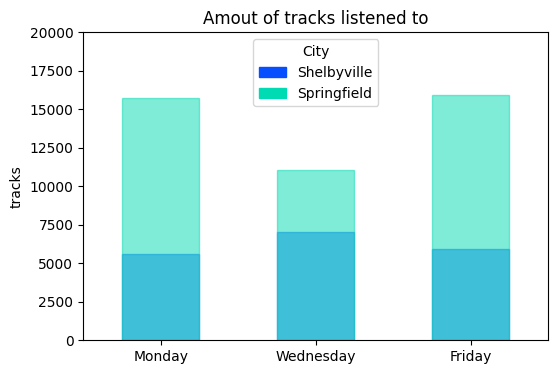

In [18]:
# plot settings
colors = ['#074EFF', '#00DBB3']
total_bars = len(pivot.columns)
indices = pivot.index.values
bar_width = 0.5

# plotting elements
fig, ax = plt.subplots()

for i, (lbl, bar_value) in enumerate(pivot.to_dict().items()):   
    # stacks
    for j, (k,v) in enumerate(bar_value.items()):
        stack = Rectangle((i + (bar_width * .5), 0), bar_width, v, color=colors[j], alpha=0.5)
        ax.add_patch(stack)

# limits
ax.set_xlim(0, 3)
ax.set_ylim(0, 20000)
fig.set_size_inches(6, 4)

# labels and ticks
ax.set_xticks([i + bar_width for i in range(total_bars)])
ax.set_xticklabels((pivot.columns.values))
plt.ylabel('tracks')
plt.title('Amout of tracks listened to')

# legend
ax.legend(handles=[Patch(color=colors[i], label=lblname) for i, lblname in enumerate(indices)],
          title = 'City')

plt.show()

In [19]:
pivot

day,Monday,Wednesday,Friday
city,,,
Shelbyville,5614,7003,5895
Springfield,15740,11056,15945


##### O dia da semana tem influência na quantidade de faixas escutadas em cada cidade?
Sim, conforme observado houveram diferenças no comportamento dos ouvintes de cada cidade, destacando-se que:
* Em Shelbyville Quarta feira é o dia com mais faixas escutadas.
* Em Springfield é o contrário, Quarta é o dia com menor quantidade.
* Segunda e Sexta possuem quantidades parecidas para ambas cidades.

Obs.:  
Por ser uma cidade maior que Shelbyville, Springfield apresenta uma quantidade maior de faixas escutadas.

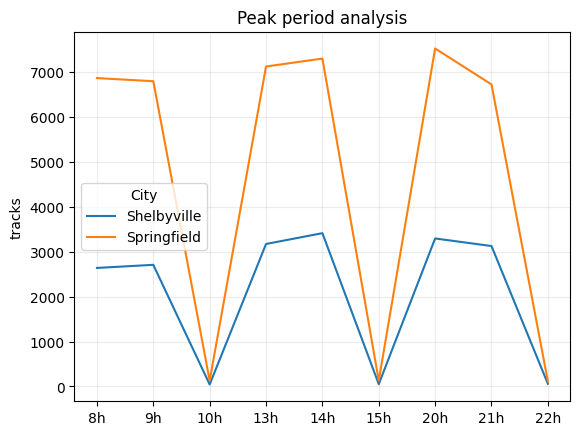

In [20]:
# Peak period
pivot = df.pivot_table(values='track', columns='hour', index='city', aggfunc='count')

# plotting
values = (pivot.values)
lbl = (pivot.index.values)

fig, ax = plt.subplots()
xtk = [f'{v}h' for v in pivot.columns.values]
plt.xticks(range(9), xtk)

for i,v in enumerate(values):
    plt.plot(v, label=lbl[i])

plt.title('Peak period analysis')
plt.ylabel('tracks')
plt.legend(title='City')
plt.grid(True, alpha=0.25)
plt.show()

In [21]:
pivot

hour,8,9,10,13,14,15,20,21,22
city,,,,,,,,,
Shelbyville,2640,2709,42,3174,3415,49,3297,3128,58
Springfield,6872,6802,127,7130,7307,127,7532,6730,114


##### Existem horários de pico?
Sim, de certa forma ambas cidades apresentaram o mesmo padrão de comportamento com relação à quantidade de músicas escutadas em determinadas horas do dia, e muito poucas em outros, conforme apresentado a seguir.

Alta quantidade de faixas reproduzidas:
* 8 às 9h (manhã)
* 13 às 14 (tarde)
* 20 às 21 (noite)

Baixa quantidade:
* 10h (manhã)
* 15h (tarde)
* 22h (noite)

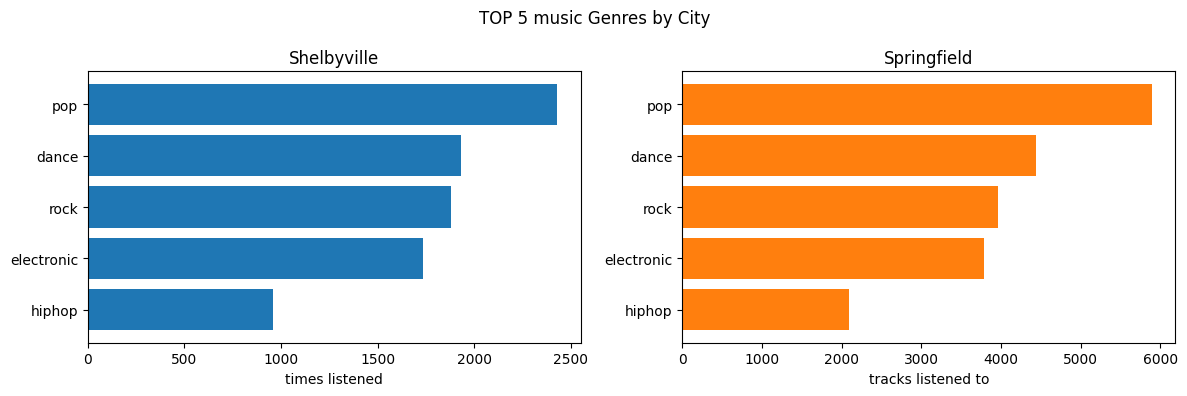

In [22]:
# TOP 5 music Genres by City
top5_shelby = df.query('city == "Shelbyville"').genre.value_counts()[:5].sort_values()
top5_spring = df.query('city != "Shelbyville"').genre.value_counts()[:5].sort_values()

# fig
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 linha, 2 colunas

# shelbyville
axs[0].barh(top5_shelby.index, top5_shelby.values, color='C0')
axs[0].set_xlabel('times listened')
axs[0].set_title('Shelbyville')

# springfield
axs[1].barh(top5_spring.index, top5_spring.values, color='C1')
axs[1].set_xlabel('tracks listened to')
axs[1].set_title('Springfield')

plt.suptitle("TOP 5 music Genres by City")

plt.tight_layout()
plt.show()

##### Cada cidade tem uma maior preferência por certos gêneros musicais?
Não, o que foi observado foi uma grande semelhança na distribuição dos TOP 5 gêneros musicais em ambas cidades:
* pop
* dance
* rock
* electronic
* hiphop

In [23]:
# TOP 5 genres each city during peaks

In [24]:
slices = [df.query(f'hour=={ts[0]} or hour=={ts[1]}') for ts in [[8,9],[13,14],[20,21]]]

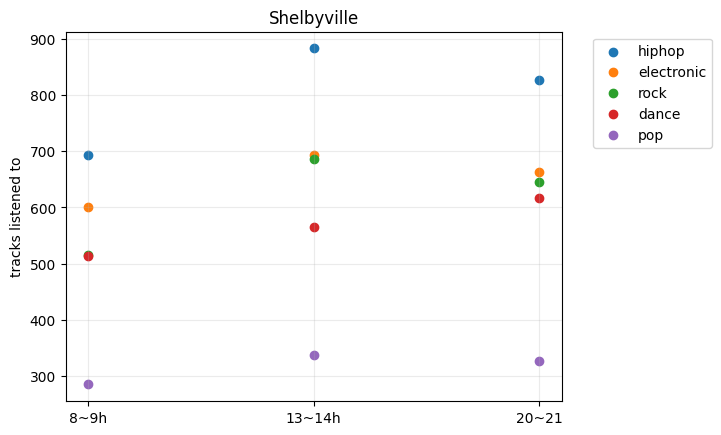

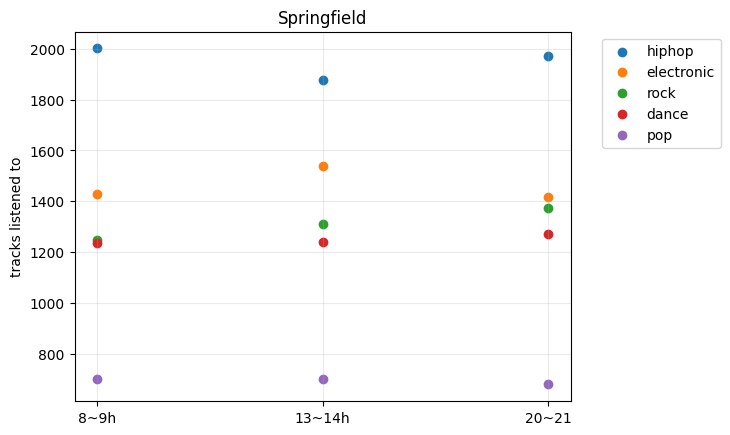

In [28]:
top5 = top5_shelby.index.values
timestamp = ['8~9h', '13~14h', '20~21']
horarios = timestamp
generos = top5

for city in ['Shelbyville', 'Springfield']:
    contagens = [slice.query(f'city == "{city}" and genre in @top5')['genre'].value_counts().values 
     for slice in slices]
    
    # Transpor a lista de contagens para que as contagens de gêneros sejam listas separadas
    contagens_transpostas = list(map(list, zip(*contagens)))
    
    # Preparar os eixos x e y
    x = range(len(horarios))
    y = contagens_transpostas

    # Criar o scatterplot
    for i, genero in enumerate(generos):
        plt.scatter(x, y[i], label=genero)
    
    # Definir rótulos dos eixos e legenda
    plt.xticks(x, horarios)
    
    plt.ylabel('tracks listened to')
    plt.legend()
    # plt.ylim(ys)
    
    plt.grid(True, alpha=0.25)
    
    plt.title(city)

    # Mova a legenda para fora do gráfico
    legend = plt.legend()
    legend.set_bbox_to_anchor((1.05, 1))
    
    plt.show()

##### Cada cidade tem preferências diferentes nos horários de pico?
Sim, porém a diferença é pontual principalmente com relação ao gênero hiphop, em que:
* Enquanto a quantidade de pessoas escutando hiphop durante a faixa das 13~14h aumenta em Shelbyville o número de pessoas escutando hiphop em Springfield diminui. 

##### Hipóteses testadas
- [x] o dia da semana tem influência na quantidade de faixas escutadas em cada cidade

- [x] existem horários de pico

- [x] cada cidade tem uma maior preferência por certos gêneros musicais

- [x] cada cidade tem preferências diferentes nos horários de pico

#### Conclusões

Em cada uma das análises Springfield apresentou maiores quantidades dos valores levantados por ser uma cidade maior que Shelbyville.

##### 1. Gêneros poulares
O gênero mais popular entre as duas cidades foi o Pop, não havendo diferenças quanto as preferências nos outros gêneros musicais. 
##### 2. Dias da semana

Durante os dias da semana __Houve__ uma diferença na quantidade de faixas escutadas entre as duas cidades na quarta feira, (Shelbyville aumentou e Springfield diminuiringfield diminui.

##### 3. Horários de pico
Com relação ao horários foi observado a presença de faixas de pico comuns entre as duas cidades que foram:

Pico de faixas reproduzidas:
* 8 às 9h (manhã)
* 13 às 14 (tarde)
* 20 às 21 (noite)

Queda de faixas reproduzidas:
* 10h (manhã)
* 15h (tarde)
* 22h (noite)

##### 4. Preferências nos horários de pico
A quantidade de pessoas escutando hiphop durante a faixa das 13~14h aumenta em Shelbyville e o número de pessoas escutando hiphop em Springfield diminui. O restante dos horários o comportamento foi similar com pequenas flutuações.